In [1]:
from astropy.table import Table, column, vstack
import astropy.units as u
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [2]:
morph_data = Table.read('fits/morph_data.fits')
structure_data = Table.read('fits/structure_data.fits')
hi_data = Table.read('fits/hi_data.fits')

gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

#### Sample selection

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


148598 galaxies in 0.01 < z < 0.055
+ 136770 have HI
+ 122776 have bulge+disc masses
+ 93351 are mass complete


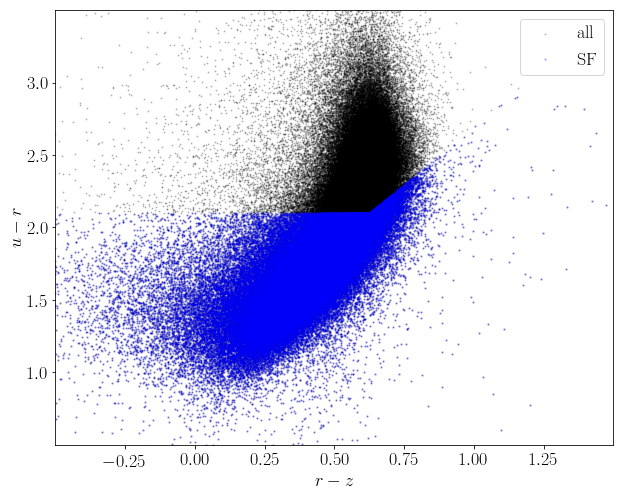

In [3]:
spiral_ok = np.all([morph_data['p_spiral'] >= 0.5,
                    morph_data['N_spiral'] >= 5,
                    morph_data['axial_ratio'] >= 0.4],axis=0)

redshift_ok = np.all([morph_data['redshift'] >= 0.01,
                      morph_data['redshift'] <= 0.085],axis=0)

hi_ok = hi_data['hi_mass'] > 0 

mass_ok = np.all([structure_data['m_b'] >= 10**7,
                  structure_data['m_d'] >= 10**7,
                  structure_data['ok']],axis=0)
mass_complete_lower = (np.log10(structure_data['m_t']) 
                    >= 2.07*np.log10(morph_data['redshift']) + 12.64)
                       
mass_complete_upper = (np.log10(structure_data['m_t']) 
                    <= 2.45*np.log10(morph_data['redshift']) + 14.05)

mass_complete = np.all([mass_complete_lower,mass_complete_upper],axis=0)

print('{} galaxies in 0.01 < z < 0.055'.format(redshift_ok.sum()))
print('+ {} have HI'.format((redshift_ok*hi_ok).sum()))
print('+ {} have bulge+disc masses'.format((redshift_ok*hi_ok*mass_ok).sum()))
print('+ {} are mass complete'.format((redshift_ok*hi_ok*mass_ok*mass_complete).sum()))

# --- Select star-forming ---
u_r = gz2_data['PETROMAG_MU'] - gz2_data['PETROMAG_MR']
r_z = gz2_data['PETROMAG_MR'] - gz2_data['PETROMAG_MZ']
star_forming = np.any([u_r < 2.1,u_r < 1.6*r_z + 1.1],axis=0)

_ = plt.scatter(r_z,u_r,color='k',s=1,alpha=0.2,label='all')
_ = plt.scatter(r_z[star_forming],u_r[star_forming],
                color='b',s=2,alpha=0.2,label='SF')
_ = plt.axis((-0.5,1.5,0.5,3.5))
_ = plt.xlabel('$r-z$')
_ = plt.ylabel('$u-r$')
_ = plt.legend()

masks = Table()
masks['in_redshift'] = redshift_ok
masks['mass_ok'] = mass_ok
masks['mass_complete'] = mass_complete
masks['hi_ok'] = hi_ok
masks['star_forming'] = star_forming

masks.write('fits/masks.fits',overwrite=True)

In [4]:
from halo import TotalHalo
sample_ok = np.all([redshift_ok,mass_ok,hi_ok],axis=0)
#sample_ok = redshift_ok

m_b = structure_data['m_b'][sample_ok].data * u.Msun
delta_m_b = structure_data['delta_m_b'][sample_ok].data * u.Msun

m_d = structure_data['m_d'][sample_ok].data * u.Msun
delta_m_d = structure_data['delta_m_d'][sample_ok].data * u.Msun

a_b = structure_data['R_b_r'][sample_ok].data * u.kpc
delta_a_b = structure_data['delta_R_b_r'][sample_ok].data * u.kpc

R_d = structure_data['R_d_r'][sample_ok].data * u.kpc
delta_R_d = structure_data['delta_R_d_r'][sample_ok].data * u.kpc

m_hi = hi_data['hi_mass'][sample_ok].data * u.Msun
delta_m_hi = hi_data['hi_mass_error'][sample_ok].data * u.Msun
#fig, axarr = plt.subplots(2,4,figsize=(20,10))

halos = TotalHalo(m_b,delta_m_b,m_d,delta_m_d,a_b,delta_a_b,
                  R_d, delta_R_d, m_hi, delta_m_hi)

In [9]:
class HistogramData():
    def __init__(self,data,data2,color,bins,log,alpha=0.3,color2='k'):
        self.data = data
        self.data2 = data2
        self.color = color
        self.bins = bins
        self.log = log
        self.alpha = alpha
        self.color2 = color2
        
    def histogram(self,ax):
        histdata = (np.log10(self.data.data) 
                    if self.log is True else self.data.data)
        _ = ax.hist(histdata,self.bins,
                    histtype='stepfilled',color=self.color,alpha=self.alpha)
        _ = ax.hist(histdata,self.bins,histtype='step',color=self.color)
        if self.data2 is not None:
            histdata2 = (np.log10(self.data2.data) 
                         if self.log is True else self.data2.data)
            _ = ax.hist(histdata2,self.bins,histtype='step',lw=3,color=self.color2)
            
    def uncertainty(self,data):
        if self.log is False:
            med_error = np.median(data.uncertainty.array)
        else:
            med_error = 0.434 * np.median(data.uncertainty.array
                                         /data.data)
        return med_error
        
            
    def uncertainty_bar(self,ax):
        (xlower,xupper), (ylower,yupper) = (ax.get_xlim(), ax.get_ylim())
        med_error = self.uncertainty(self.data)
        x_pos, y_pos = (0.05*(xupper-xlower) + xlower,
                        0.85*(yupper-ylower) + ylower)
        _ = ax.errorbar(x_pos,y_pos,xerr=([0],[med_error]),
                        lw=2,capthick=2,capsize=2,color=self.color)
        
        if self.data2 is not None:
            med_error = self.uncertainty(self.data2)
            x_pos, y_pos = (0.05*(xupper-xlower) + xlower,
                            0.75*(yupper-ylower) + ylower)
            _ = ax.errorbar(x_pos,y_pos,xerr=([0],[med_error]),
                            lw=2,capthick=2,capsize=2,color=self.color2)
            
    def median_line(self,ax,printout=False):
        plt.sca(ax)
        med_ = (np.median(np.log10(self.data)) if self.log is True 
                else np.median(self.data))
        _ = plt.axvline(med_,color=self.color,lw=2,linestyle='dashed')
        print(med_) if printout is True else None
            
        if self.data2 is not None:
            med_ = (np.median(np.log10(self.data2)) if self.log is True 
                else np.median(self.data2))
            _ = plt.axvline(med_,color=self.color2,lw=2,linestyle='dashed')
            print(med_) if printout is True else None


data = [HistogramData(halos.disc_mass(hi=False),halos.disc_mass(hi=True),
                      'y',np.linspace(8,12,21),True),
        
        HistogramData(halos.stellar_disc_scale_length(),
                      halos.disc_scale_length(),
                      'y',np.linspace(0,10,20),False),
        
        HistogramData(halos.bulge_mass(),None,'b',np.linspace(8,12,21),True),
       
        HistogramData(halos.bulge_scale_length(),None,'b',
                      np.linspace(0,10,20),False),
        
        HistogramData(halos.halo_mass(),None,'r',np.linspace(10,14,21),True),
        
        HistogramData(halos.halo_scale_length(),None,'r',
                      np.linspace(5,65,21),False)]

10.0500001907
10.3003362926
2.23333326976
4.04882620253
10.267999649
1.5733332634
12.107615095
27.5797919605


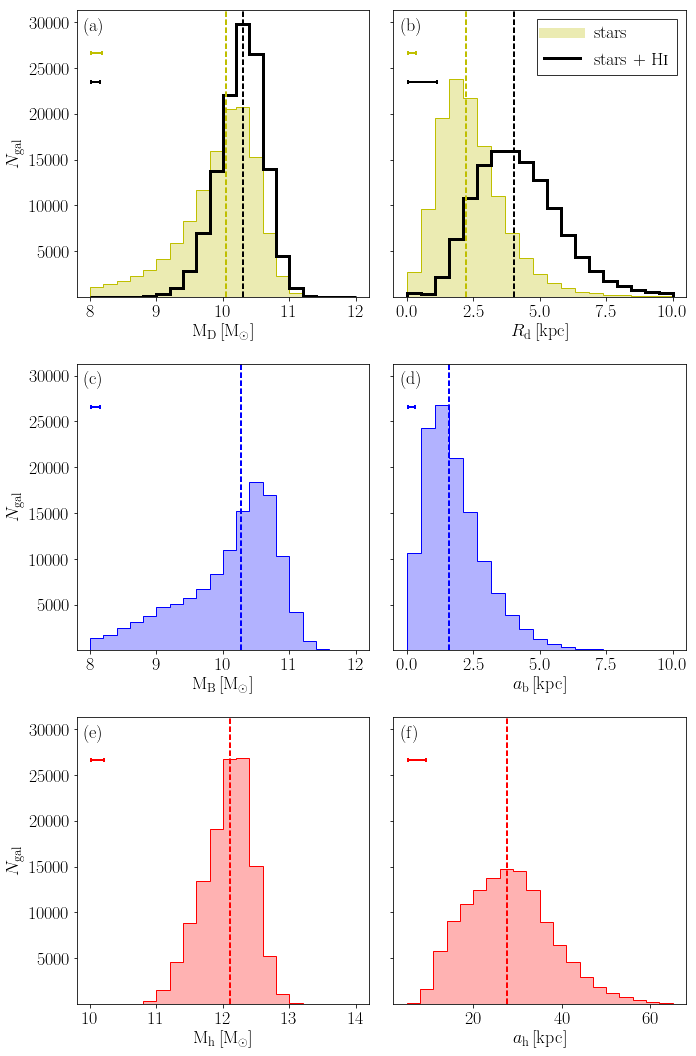

In [10]:
fig, axarr = plt.subplots(3,2,figsize=(10,15),sharey=True)

xlabels = ('$\mathrm{M_D} \, [\mathrm{M_\odot}]$',
           '$R_\mathrm{d} \, [\mathrm{kpc}]$',
           '$\mathrm{M_B} \, [\mathrm{M_\odot}]$',
           '$a_\mathrm{b} \, [\mathrm{kpc}]$',
           '$\mathrm{M_h} \, [\mathrm{M_\odot}]$',
           '$a_\mathrm{h} \, [\mathrm{kpc}]$')

letters = 'abcdef'

for ax in axarr[:,0]:
    ax.set_ylabel('$N_\mathrm{gal}$')
    
axarr = axarr.ravel()

for ax, d, xlabel,letter in zip(axarr,data,xlabels,letters):
    plt.sca(ax)
    _ = d.histogram(ax)
    _ = d.median_line(ax,True)
    _ = d.uncertainty_bar(ax)
    _ = ax.set_xlabel(xlabel)
    _ = ax.text(0.025,0.975,'({})'.format(letter),
                transform=ax.transAxes,ha='left',va='top')
    
_ = fig.tight_layout()

_ = axarr[1].plot([],[],color='y',lw=10,alpha=0.3,label='stars')
_ = axarr[1].plot([],[],color='k',lw=3,label=r'stars + H\textsc{i}')
_ = axarr[1].legend(loc='upper right',
                    edgecolor='k',fancybox=False)

fig.savefig('figures/parameter_histograms.pdf')

In [11]:
halo_table = Table()

halo_table['M_disc_stars'] = halos.disc_mass(hi=False).data
halo_table['delta_M_disc_stars'] = halos.disc_mass(hi=False).uncertainty.array

halo_table['M_disc_total'] = halos.disc_mass(hi=True).data
halo_table['delta_M_disc_total'] = halos.disc_mass(hi=True).uncertainty.array

halo_table['R_disc_stars'] = halos.stellar_disc_scale_length().data
halo_table['delta_R_disc_stars'] = halos.stellar_disc_scale_length().uncertainty.array

halo_table['R_disc_total'] = halos.disc_scale_length().data
halo_table['delta_R_disc_total'] = halos.disc_scale_length().uncertainty.array

halo_table['M_bulge'] = halos.bulge_mass().data
halo_table['delta_M_bulge'] = halos.bulge_mass().uncertainty.array

halo_table['R_bulge'] = halos.bulge_scale_length().data
halo_table['delta_R_bulge'] = halos.bulge_scale_length().uncertainty.array

halo_table['M_halo'] = halos.halo_mass().data
halo_table['delta_M_halo'] = halos.halo_mass().uncertainty.array

halo_table['R_halo'] = halos.halo_scale_length().data
halo_table['delta_R_halo'] = halos.halo_scale_length().uncertainty.array

r_d = [1,1.5,2,2.2]
for r in r_d:
    m_pred = halos.m_hernquist(y=r/2)
    halo_table['m_predicted_{}R_d'.format(r)] = m_pred['m']


In [12]:
halo_table['M_disc_stars_2.2'] = 0.645 * halo_table['M_disc_stars']
halo_table['M_disc_total_2.2'] = 0.645 * halo_table['M_disc_total']
halo_table['M_bulge_2.2'] = ((2.2 * halo_table['R_disc_total'])**2
                          / (2.2 * halo_table['R_disc_total'] + halo_table['R_bulge'])**2
                          * halo_table['M_bulge'])   

halo_table['M_halo_2.2'] = ((2.2 * halo_table['R_disc_total'])**2
                          / (2.2 * halo_table['R_disc_total'] + halo_table['R_halo'])**2
                          * halo_table['M_halo']) 

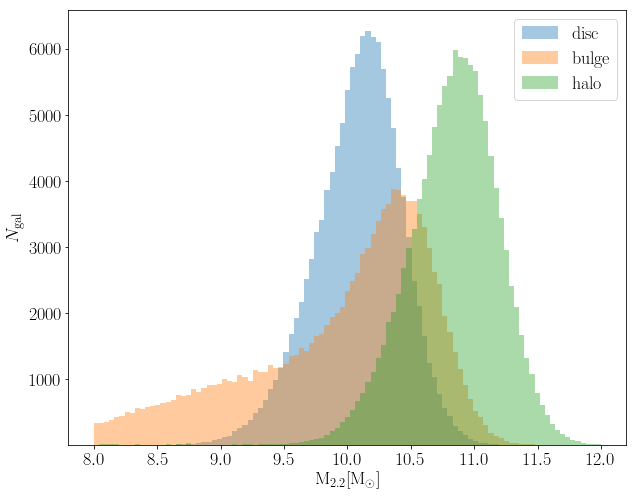

In [23]:
bins = np.linspace(8,12,100)

_ = plt.hist(np.log10(halo_table['M_disc_total_2.2']),bins,label='disc',alpha=0.4)
_ = plt.hist(np.log10(halo_table['M_bulge_2.2']),bins,label='bulge',alpha=0.4)
_ = plt.hist(np.log10(halo_table['M_halo_2.2']),bins,label='halo',alpha=0.4)

_ = plt.xlabel('$\mathrm{M_{2.2} [M_\odot]}$')
_ = plt.ylabel('$N_\mathrm{gal}$')
_ = plt.legend()

In [21]:
halo_table_all = Table()
for c in halo_table.colnames:
    halo_table_all[c] = np.full(len(gz2_data),-999,dtype='float64')
    halo_table_all[c][sample_ok] = halo_table[c]

halo_table_all['dr7objid'] = gz2_data['dr7objid']
halo_table_all['mask'] = sample_ok

halo_table.write('fits/halo_table.fits',overwrite=True)
halo_table_all.write('fits/halo_table_all.fits',overwrite=True)